In [1]:
import os

import numpy as np
import pandas as pd

import scanpy as sc

In [2]:
os.chdir("./Scanpy_all_new")

In [3]:
import time
import logging
logging.basicConfig(filename='./logging.txt', level=logging.INFO)

In [3]:
sc.set_figure_params(dpi=80, dpi_save=300)

In [33]:
import glob
file_names = glob.glob("../../orig_data/MCA/*")
adata_lists = []
for fname in file_names:
    adata = sc.AnnData(pd.read_csv(fname, sep=' ').fillna(0).T)
    basename = os.path.basename(fname).split('-')[-1]
    adata.obs['Batch'] = os.path.basename(fname).replace("_dge.txt.gz", '')
    adata_lists.append(adata)

In [66]:
adata_lists[0].X.shape

0.045294374

In [34]:
dge = adata_lists[0].concatenate(adata_lists[1:], join='outer')

In [73]:
#check
print(dge.shape)
print(dge.obs_names[1:5])
print(dge.var_names[1:5])
dge.X[1,30000]

(47508, 30702)
Index(['Liver_1.CTCGCAGGACATACACCC-0', 'Liver_1.ATTCCAGCCTAGATCTCT-0',
       'Liver_1.AAAACGTCTACCACTTAT-0', 'Liver_1.CCTAGAAAAGTTAAGTAC-0'],
      dtype='object')
Index(['0610005C13Rik', '0610007P14Rik', '0610009B22Rik', '0610009E02Rik'], dtype='object')


nan

In [74]:
dge.X[np.isnan(dge.X)] = 0

In [5]:
dge = sc.read_h5ad("../Scanpy_all/proc_data/dge.h5ad")

In [158]:
anno_df = pd.DataFrame(dge.obs_names.values, columns=['CellID'])
anno_df['MCA_CellID'] = anno_df['CellID'].apply(lambda x: x.split('-')[0])
anno_df['Tissue'] = anno_df['CellID'].apply(lambda x: x.split('_')[0])

In [159]:
MCA_anno_df = pd.read_csv("../../orig_data/cell-ann.csv", header=0, index_col=0, sep=',').drop(['Batch','Tissue'], axis=1)

In [160]:
merged_anno_df = anno_df.join(MCA_anno_df, on='MCA_CellID', how='left')[['CellID', 'Cell.Anno', 'Tissue' ]]

In [161]:
celltype_dict = { line.rstrip().split(',')[0] : line.rstrip().split(',')[1] for line in open("../../orig_data/anno.csv", 'r') }
def proc_cellAnno(x):
    x = str(x)
    if x in celltype_dict.keys():
        return celltype_dict[x]
    else:
        return x+'__CHECK__'
merged_anno_df['CellType'] = merged_anno_df['Cell.Anno'].apply(proc_cellAnno)

In [162]:
for i in merged_anno_df.columns.values:
    dge.obs[i] = merged_anno_df[i].values

In [164]:
#check
print(dge.obs['CellID'][1:5])
print(dge.obs['Batch'].unique())
print(dge.obs['Batch'].describe())
print(dge.obs['Tissue'].unique())
print(dge.obs['CellType'].unique())
print(dge.obs['CellType'].describe())
print(dge)

index
Liver_1.CTCGCAGGACATACACCC-0    Liver_1.CTCGCAGGACATACACCC-0
Liver_1.ATTCCAGCCTAGATCTCT-0    Liver_1.ATTCCAGCCTAGATCTCT-0
Liver_1.AAAACGTCTACCACTTAT-0    Liver_1.AAAACGTCTACCACTTAT-0
Liver_1.CCTAGAAAAGTTAAGTAC-0    Liver_1.CCTAGAAAAGTTAAGTAC-0
Name: CellID, dtype: object
[Liver1, Lung2, Spleen, Lung1, Lung3, ..., Kidney2, Uterus1, Pancreas, SmallIntestine3, SmallIntestine2]
Length: 15
Categories (15, object): [Liver1, Lung2, Spleen, Lung1, ..., Uterus1, Pancreas, SmallIntestine3, SmallIntestine2]
count       47508
unique         15
top       Kidney2
freq         6220
Name: Batch, dtype: object
['Liver' 'Lung' 'Spleen' 'Brain' 'Bladder' 'Ovary' 'Uterus' 'Kidney'
 'Pancreas' 'SmallIntestine']
['B cell' 'Hepatocyte' 'other' 'Granulocyte' 'Endothelial cell'
 'Kupffer cell' 'Epithelial cell' 'Macrophage' 'Dendritic cell' 'T cell'
 'Erythroblast' 'Stromal cell' 'Neutrophil' 'Clara cell' 'Ciliated cell'
 'AT2 cell' 'AT1 cell' 'Dividing cell' 'Monocyte' 'NK cell' 'Nuocyte'
 'Eosinophil' 

In [165]:
adata = dge.copy()

In [1]:
adata

NameError: name 'adata' is not defined

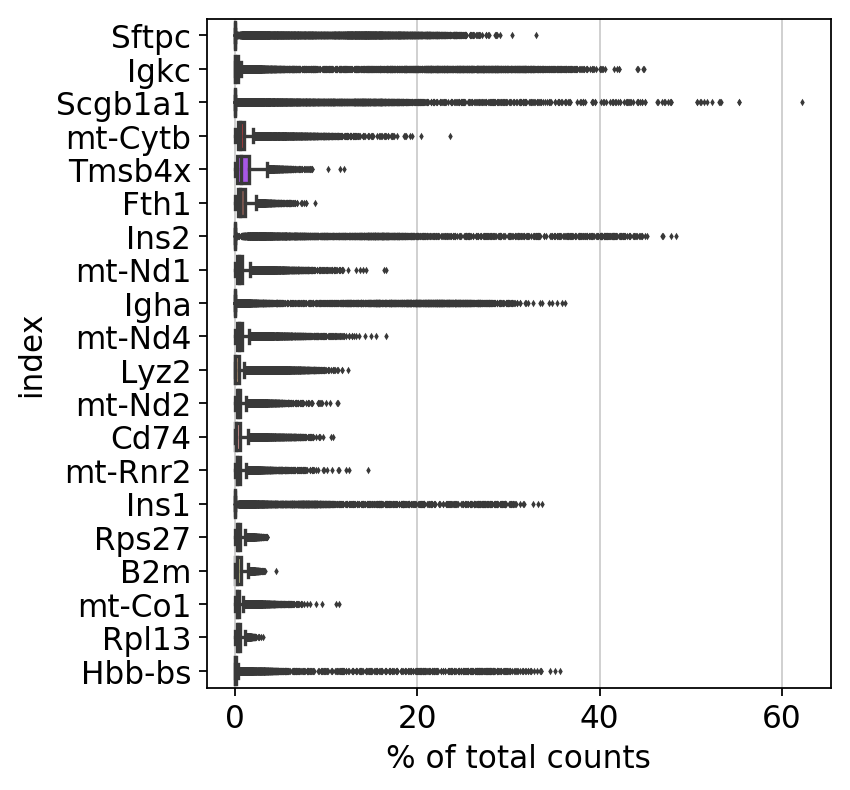

In [44]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [47]:
# filter
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=3)

In [48]:
adata

AnnData object with n_obs × n_vars = 25656 × 23959 
    obs: 'Batch', 'batch', 'CellID', 'Cell.Anno', 'Tissue', 'CellType', 'n_genes'
    var: 'n_cells'

In [49]:
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)

... storing 'Cell.Anno' as categorical
... storing 'Tissue' as categorical
... storing 'CellType' as categorical


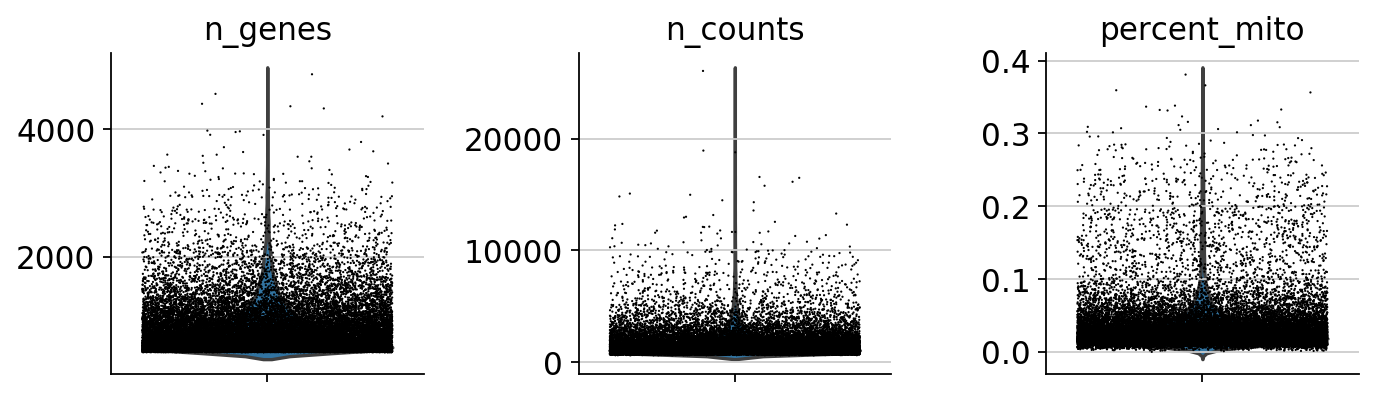

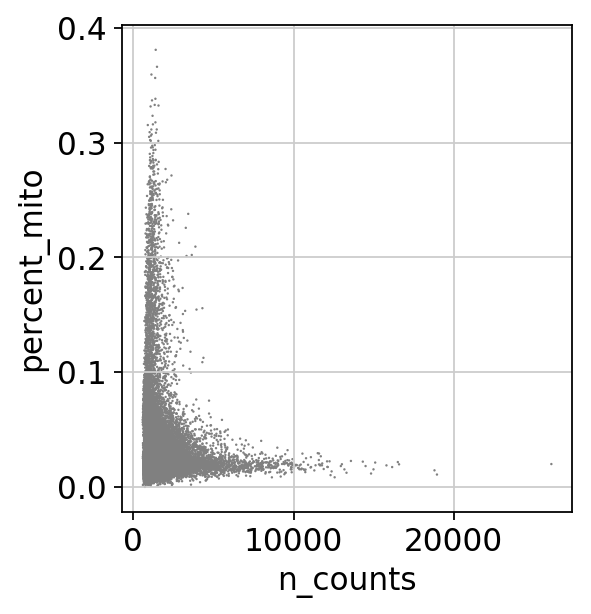

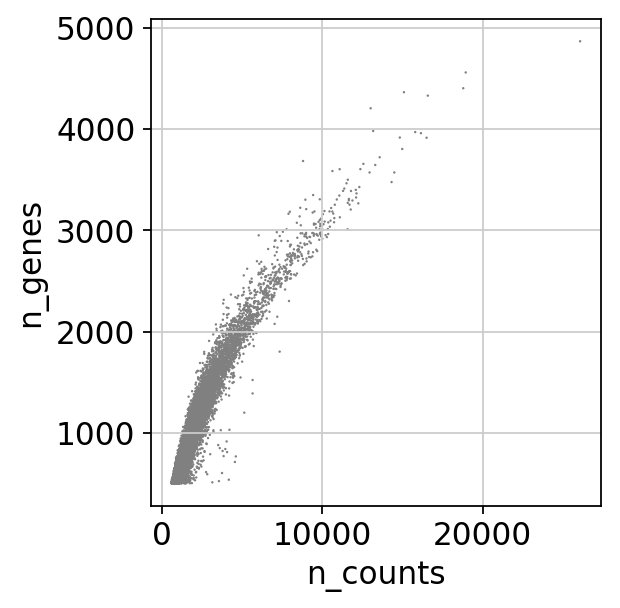

In [50]:
## filter the cells
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'],jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [51]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.3, :]

In [52]:
adata

View of AnnData object with n_obs × n_vars = 25627 × 23959 
    obs: 'Batch', 'batch', 'CellID', 'Cell.Anno', 'Tissue', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [53]:
## normalize
sc.pp.normalize_per_cell(adata)
adata.raw = sc.pp.log1p(adata, copy=True)

In [54]:
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.01, max_mean=15, min_disp=0.25)# 2618genes

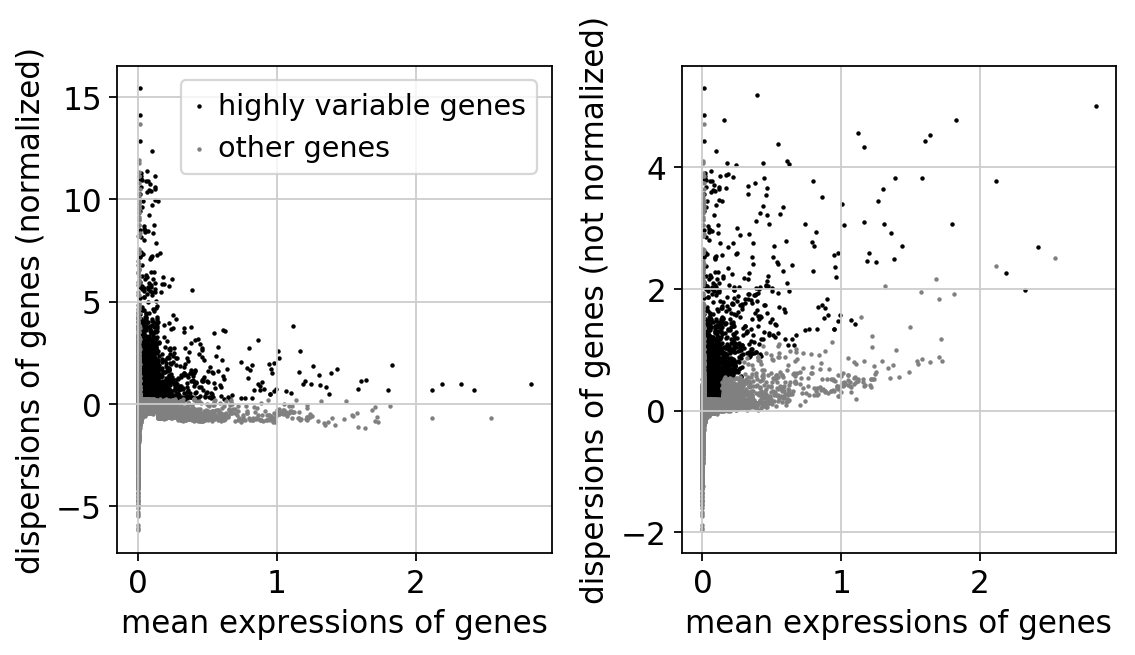

(25627, 2618)

In [55]:
sc.pl.filter_genes_dispersion(filter_result)
adata[:, filter_result.gene_subset].shape

In [56]:
hvgs = adata.var_names[filter_result.gene_subset]

In [57]:
## Actually do the filtering.
#adata1=adata
adata = adata[:, filter_result.gene_subset]

In [4]:
adata_base = sc.read_h5ad("adata_base.h5ad")

In [5]:
adata_base.obs['Tissue'] = adata_base.obs_names.values
adata_base.obs['Tissue'] = adata_base.obs['Tissue'].apply(lambda x: x.split('_')[0])
adata_base.obs['Tissue'].unique()

array(['Liver', 'Lung', 'Spleen', 'Brain', 'Bladder', 'Ovary', 'Uterus',
       'Kidney', 'Pancreas', 'SmallIntestine'], dtype=object)

In [58]:
adata_base = adata.copy()

In [59]:
## scale the data
sc.pp.scale(adata_base, max_value=10)

In [60]:
## PCA
sc.tl.pca(adata_base)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [61]:
#nPC=45
sc.pp.neighbors(adata_base, n_neighbors=10,n_pcs=45)

In [62]:
#run tSNE
sc.tl.tsne(adata_base,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

... storing 'Tissue' as categorical


saving figure to file ./figures/tsne_Batch_Baseline.svg


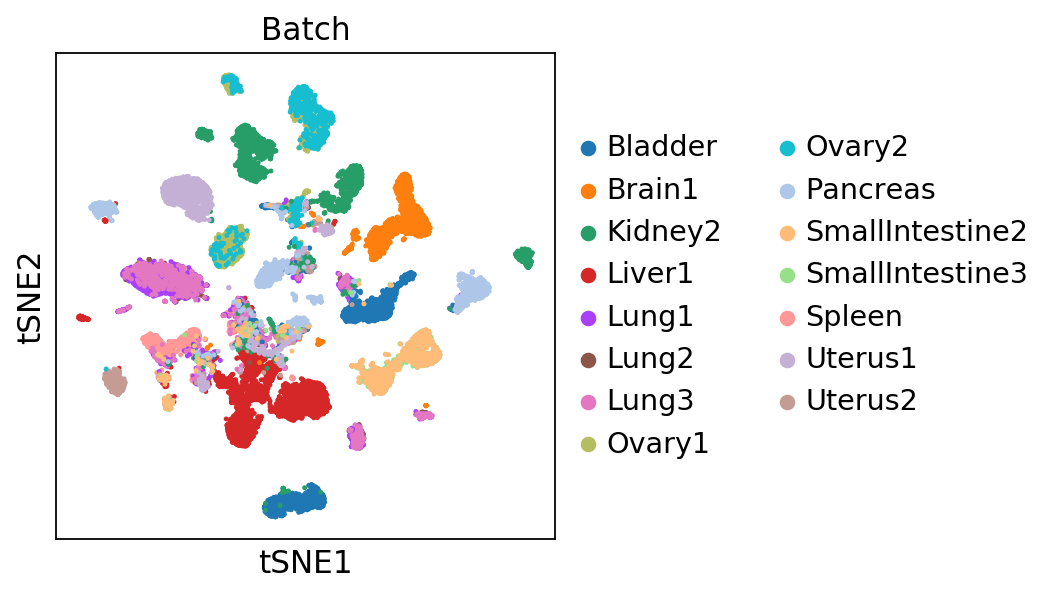

In [6]:
sc.pl.tsne(adata_base, color=['Batch'], size=20, wspace=40, hspace=40, save="_Batch_Baseline.svg")

saving figure to file ./figures/tsne_CellType_Baseline.svg


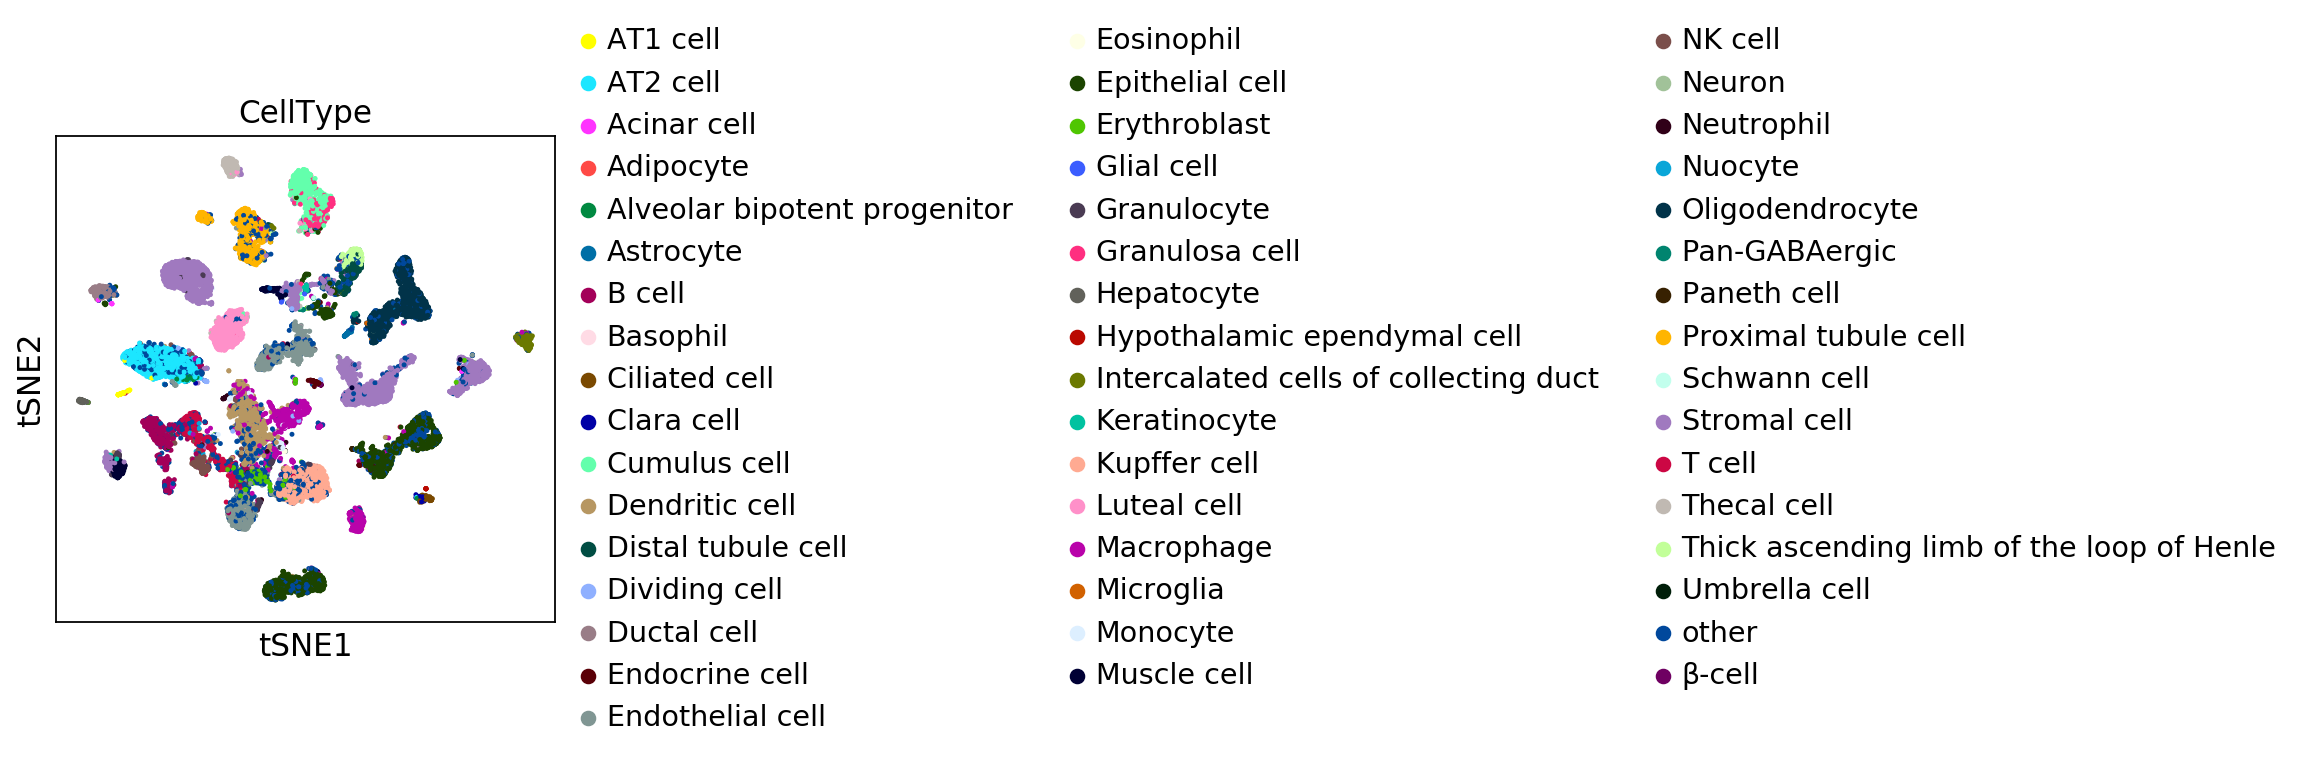

In [7]:
sc.pl.tsne(adata_base, color=['CellType'], size=20, save="_CellType_Baseline.svg")

saving figure to file ./figures/tsne_Tissue_Baseline.svg


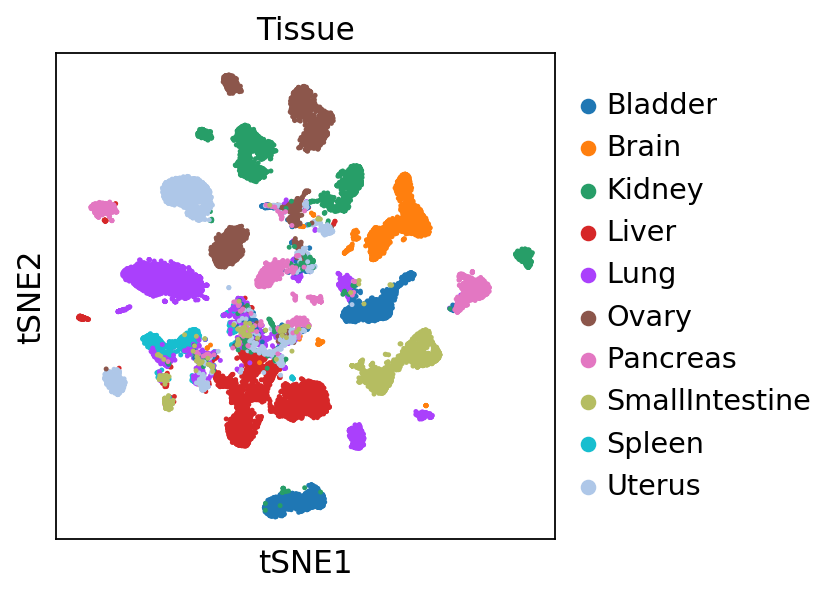

In [8]:
sc.pl.tsne(adata_base, color=['Tissue'], size=20, save="_Tissue_Baseline.svg")

In [121]:
#res=0.6
sc.tl.louvain(adata_base, resolution=0.6)

saving figure to file ./figures/tsne_Cluster_baseline.svg


/home/ggj/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


saving figure to file ./figures/tsne_Cluster_baseline.svg


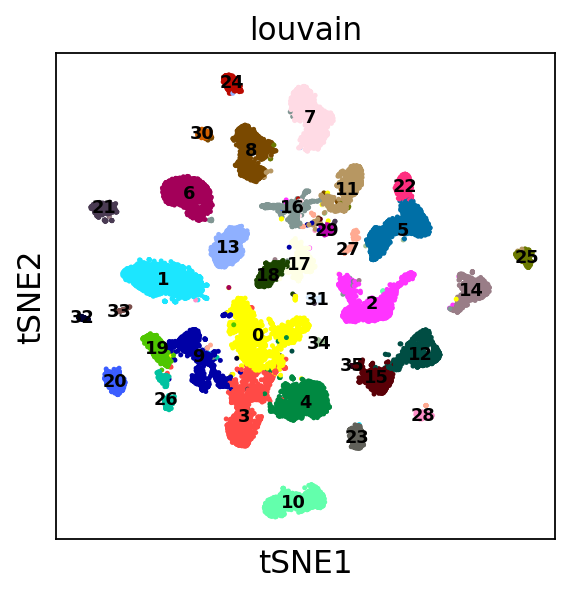

In [9]:
sc.pl.tsne(adata_base, color='louvain',size=20, legend_loc='on data', legend_fontsize=8, save='_Cluster_baseline.svg')

In [66]:
adata_base.obs['louvain'].to_csv("./cluster_Baseline.txt", index=False)

In [67]:
adata_reg = adata.copy()

In [10]:
adata_reg = sc.read_h5ad("adata_reg.h5ad")

In [11]:
adata_reg.obs['Tissue'] = adata_reg.obs_names.values
adata_reg.obs['Tissue'] = adata_reg.obs['Tissue'].apply(lambda x: x.split('_')[0])
adata_reg.obs['Tissue'].unique()

array(['Liver', 'Lung', 'Spleen', 'Brain', 'Bladder', 'Ovary', 'Uterus',
       'Kidney', 'Pancreas', 'SmallIntestine'], dtype=object)

In [68]:
## Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
logging.info("start scanpy regout\n\n")
start = time.clock()
sc.pp.regress_out(adata_reg, ['n_counts'])
end = time.clock()
logging.info("time scale: second")
logging.info("scanpy regout total running time:\t%f", end - start)
logging.info("\n\nscanpy regout")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [69]:
## scale the data
sc.pp.scale(adata_reg, max_value=10)

In [70]:
## PCA
sc.tl.pca(adata_reg)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [71]:
#nPC=45
sc.pp.neighbors(adata_reg, n_neighbors=10,n_pcs=45)

In [72]:
#run tSNE
sc.tl.tsne(adata_reg,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

... storing 'Tissue' as categorical


saving figure to file ./figures/tsne_Batch_reg.svg


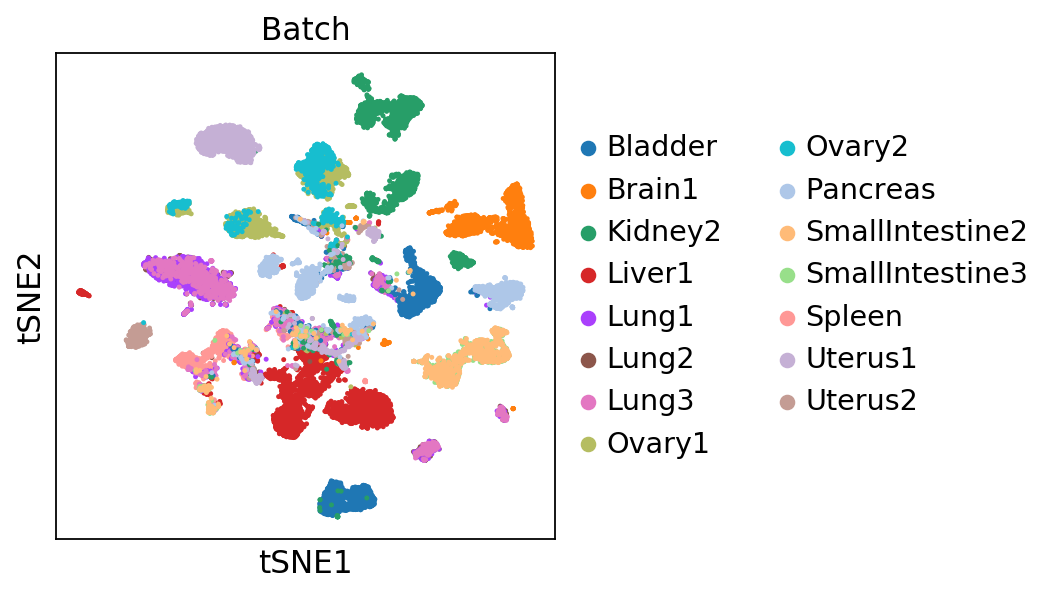

In [12]:
sc.pl.tsne(adata_reg, color=['Batch'], size=20, save="_Batch_reg.svg")

saving figure to file ./figures/tsne_CellType_reg.svg


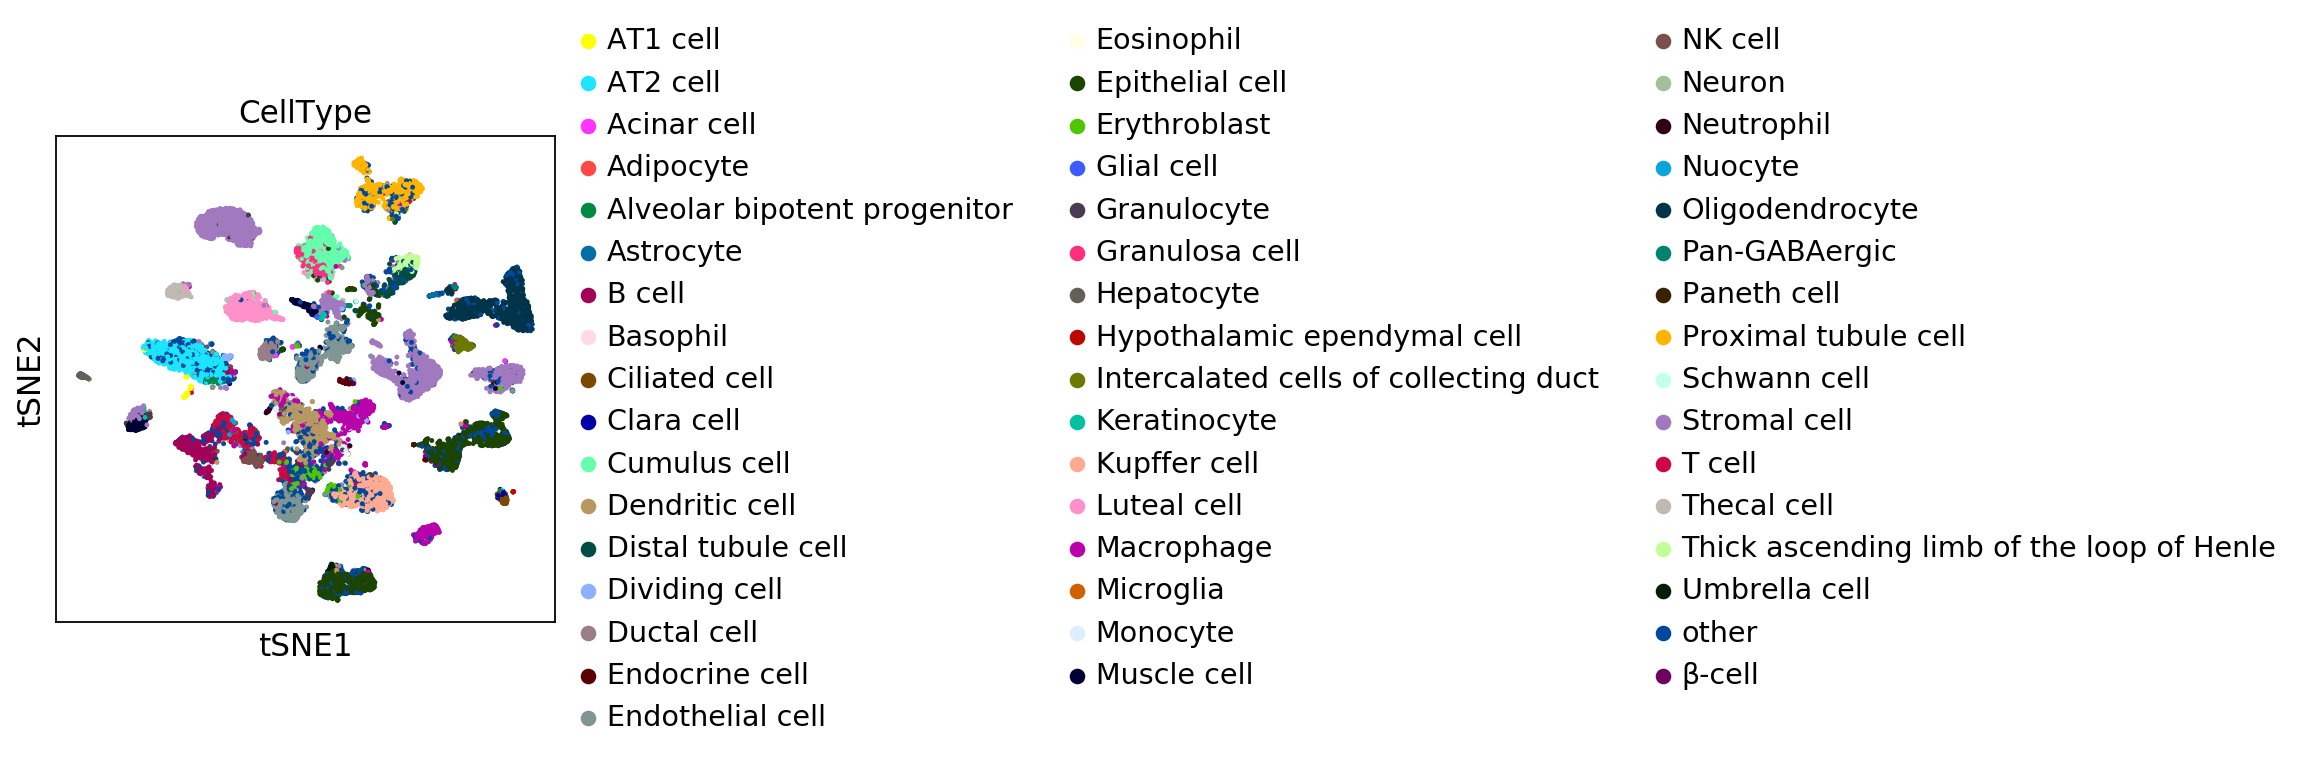

In [13]:
sc.pl.tsne(adata_reg, color=['CellType'], size=20, save="_CellType_reg.svg")

saving figure to file ./figures/tsne_Tissue_Reg.svg


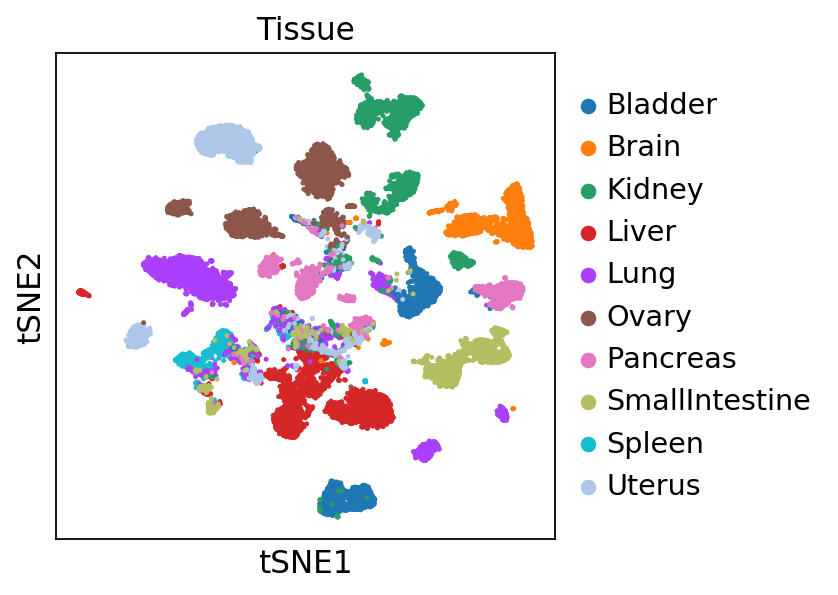

In [14]:
sc.pl.tsne(adata_reg, color=['Tissue'], size=20, save="_Tissue_Reg.svg")

saving figure to file ./figures/tsne_Cluster_reg.svg


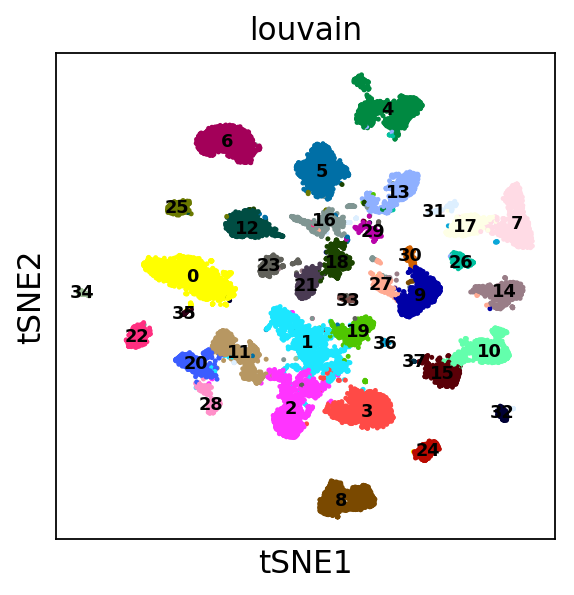

In [15]:
#res=0.6
sc.tl.louvain(adata_reg, resolution=0.6)
sc.pl.tsne(adata_reg, color='louvain',size=20,legend_loc='on data', legend_fontsize=8, save='_Cluster_reg.svg')

In [77]:
adata_reg.obs['louvain'].to_csv("./cluster_Reg.txt", index=False)

In [78]:
adata_base.write("./proc_data/adata_base.h5ad")

In [80]:
adata_combat = adata.copy()

In [16]:
adata_combat = sc.read_h5ad("adata_combat.h5ad")

In [17]:
adata_combat.obs['Tissue'] = adata_combat.obs_names.values
adata_combat.obs['Tissue'] = adata_combat.obs['Tissue'].apply(lambda x: x.split('_')[0])
adata_combat.obs['Tissue'].unique()

array(['Liver', 'Lung', 'Spleen', 'Brain', 'Bladder', 'Ovary', 'Uterus',
       'Kidney', 'Pancreas', 'SmallIntestine'], dtype=object)

In [81]:
logging.info("start scanpy combat\n\n")
start = time.clock()
sc.pp.combat(adata_combat, key='Batch')
end = time.clock()
logging.info("time scale: second")
logging.info("scanpy combat running time:\t%f", end - start)
logging.info("\n\nEnd scanpy combat")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
Standardizing Data across genes.
found 15 batches
found 0 categorical variables:	
Fitting L/S model and finding priors
Finding parametric adjustments
/home/ggj/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:196: RuntimeWarning: divide by zero encountered in true_divide
  b_prior[i],


Adjusting data


/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [82]:
## scale the data
sc.pp.scale(adata_combat, max_value=10)

In [83]:
## PCA
sc.tl.pca(adata_combat)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [84]:
#nPC=45
sc.pp.neighbors(adata_combat, n_neighbors=10,n_pcs=45)

In [85]:
#run tSNE
sc.tl.tsne(adata_combat,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

... storing 'Tissue' as categorical


saving figure to file ./figures/tsne_Batch_Combat.svg


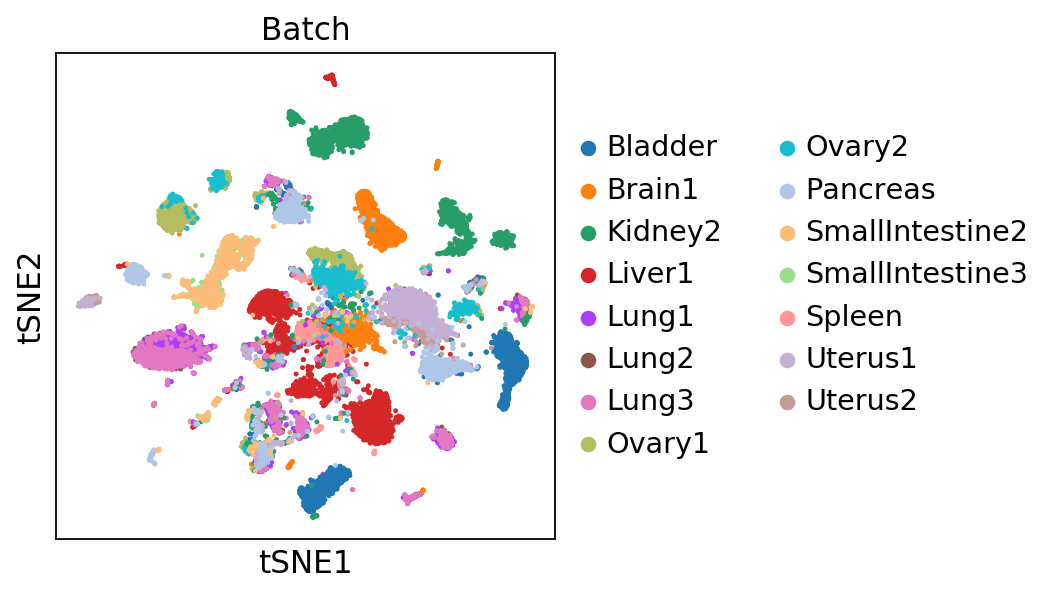

In [18]:
sc.pl.tsne(adata_combat, color=['Batch'], size=20, save="_Batch_Combat.svg")

saving figure to file ./figures/tsne_CellType_Combat.svg


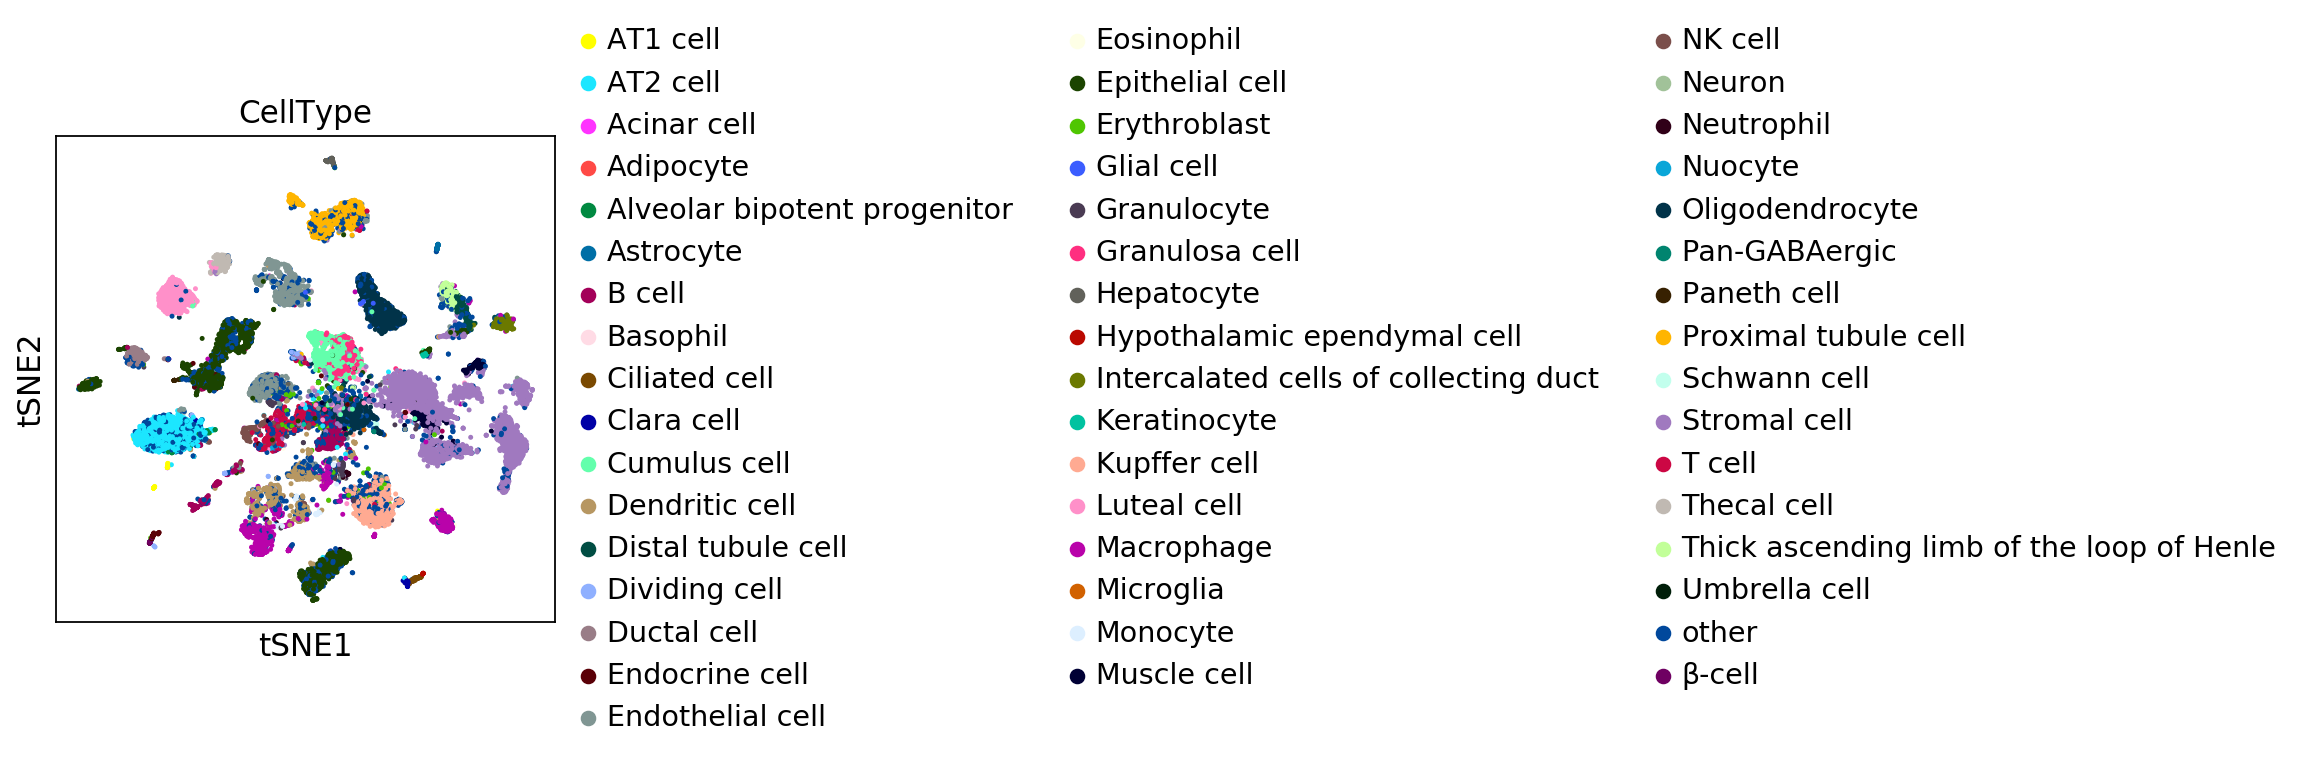

In [19]:
sc.pl.tsne(adata_combat, color=['CellType'], size=20, save="_CellType_Combat.svg")

saving figure to file ./figures/tsne_Tissue_Combat.svg


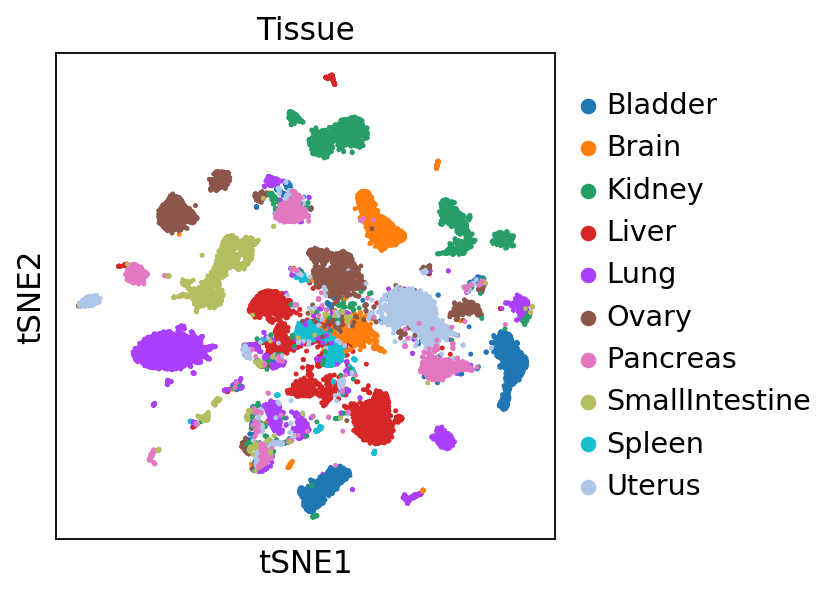

In [20]:
sc.pl.tsne(adata_combat, color=['Tissue'], size=20, save="_Tissue_Combat.svg")

saving figure to file ./figures/tsne_Cluster_Combat.svg


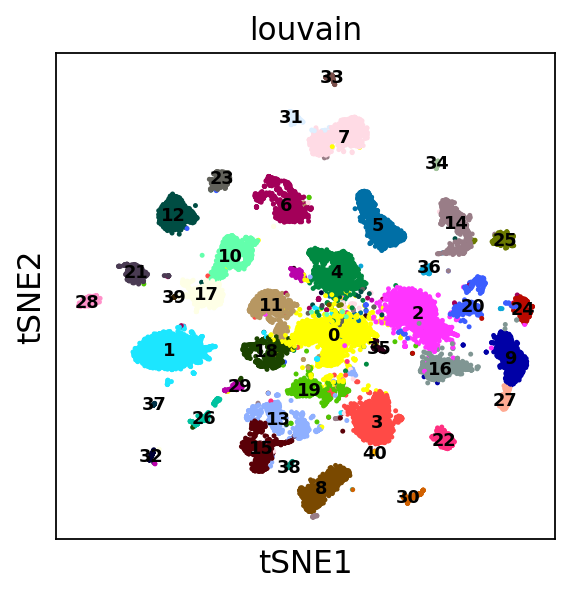

In [21]:
#res=0.6
sc.tl.louvain(adata_combat, resolution=0.6)
sc.pl.tsne(adata_combat, color='louvain',size=20,legend_loc='on data', legend_fontsize=8,save='_Cluster_Combat.svg')

In [90]:
adata_combat.obs['louvain'].to_csv("./cluster_Combat.txt", index=False)

In [91]:
adata_scanorama = adata.copy()

In [22]:
corrected_merged_dge = sc.read_h5ad("./adata_scanorama.h5ad")

In [23]:
corrected_merged_dge.obs['Tissue'] = corrected_merged_dge.obs_names.values
corrected_merged_dge.obs['Tissue'] = corrected_merged_dge.obs['Tissue'].apply(lambda x: x.split('_')[0])
corrected_merged_dge.obs['Tissue'].unique()

array(['Liver', 'Lung', 'Spleen', 'Brain', 'Bladder', 'Ovary', 'Uterus',
       'Kidney', 'Pancreas', 'SmallIntestine'], dtype=object)

In [92]:
adata_list = [adata_scanorama[adata_scanorama.obs['Batch'] == i] for i in adata_scanorama.obs['Batch'].unique()]

In [93]:
#check
print(adata_list[0].shape)
print(adata_list[0])

(3482, 2618)
View of AnnData object with n_obs × n_vars = 3482 × 2618 
    obs: 'Batch', 'batch', 'CellID', 'Cell.Anno', 'Tissue', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'


In [94]:
import scanorama

In [95]:
logging.info("start scanorama\n\n")
start = time.clock()
intergrated, corrected = scanorama.correct_scanpy(adata_list, return_dimred=True)
correct_end = time.clock()
corrected_merged_dge = corrected[0].concatenate(corrected[1:], join='outer')
merged_end = time.clock()
logging.info("time scale: second")
logging.info("scanoram correct batch time:\t%f", correct_end - start)
logging.info("scanoram merging time:\t%f", merged_end - correct_end)
logging.info("scanoram total running time:\t%f", merged_end - start)
logging.info("\n\nend scanorama")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Found 2618 genes among all datasets
[[0.00000000e+00 3.02690583e-02 2.65249538e-01 4.01704200e-02
  8.96551724e-03 1.23492246e-02 3.79092476e-02 8.01263642e-02
  8.17694370e-02 5.74382539e-03 7.03618610e-02 6.70698186e-02
  3.67541766e-02 6.76532770e-02 3.50350350e-02]
 [0.00000000e+00 0.00000000e+00 1.84842884e-02 6.45739910e-01
  9.11434978e-01 1.12107623e-03 2.00378072e-02 4.48430493e-03
  2.01072386e-02 2.24215247e-03 5.60538117e-03 1.56950673e-02
  4.48430493e-03 8.45665962e-03 1.12107623e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.14972274e-02
  4.25138632e-02 0.00000000e+00 8.59519409e-02 1.66358595e-02
  8.31792976e-03 9.52380952e-04 4.52865065e-02 1.40480591e-01
  2.03327172e-02 1.41404806e-01 1.05360444e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.79310345e-01 4.86914181e-03 1.93194707e-01 1.33901400e-02
  5.09383378e-02 2.43457091e-03 1.46074254e-02 1.92413414e-02
  3.96181384e-02 1.26849894e-02 7.00700701e-03]
 [0.00000000e+00 0.00000000e

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/home/ggj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/ggj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Pytho

In [96]:
corrected_merged_dge.obs = adata_scanorama.obs

In [97]:
## scale the data
sc.pp.scale(corrected_merged_dge, max_value=10)

In [98]:
## PCA
sc.tl.pca(corrected_merged_dge)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [99]:
#nPC=45
sc.pp.neighbors(corrected_merged_dge, n_neighbors=10,n_pcs=45)

In [100]:
#run tSNE
sc.tl.tsne(corrected_merged_dge,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

... storing 'Tissue' as categorical


saving figure to file ./figures/tsne_Batch_Scanorama.svg


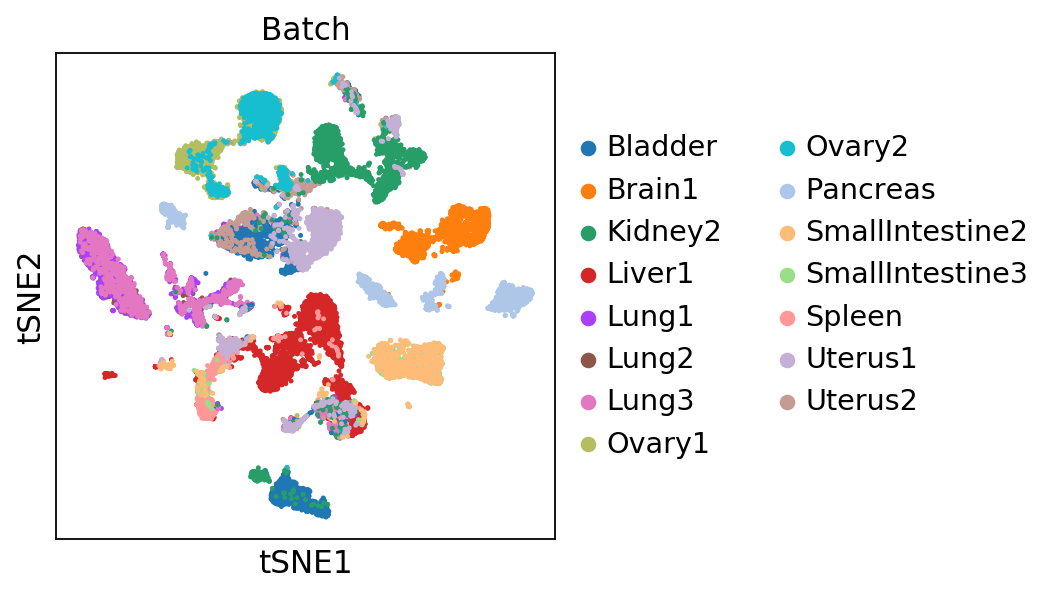

In [24]:
sc.pl.tsne(corrected_merged_dge, color=['Batch'], size=20, save="_Batch_Scanorama.svg")

saving figure to file ./figures/tsne_CellType_Scanorama.svg


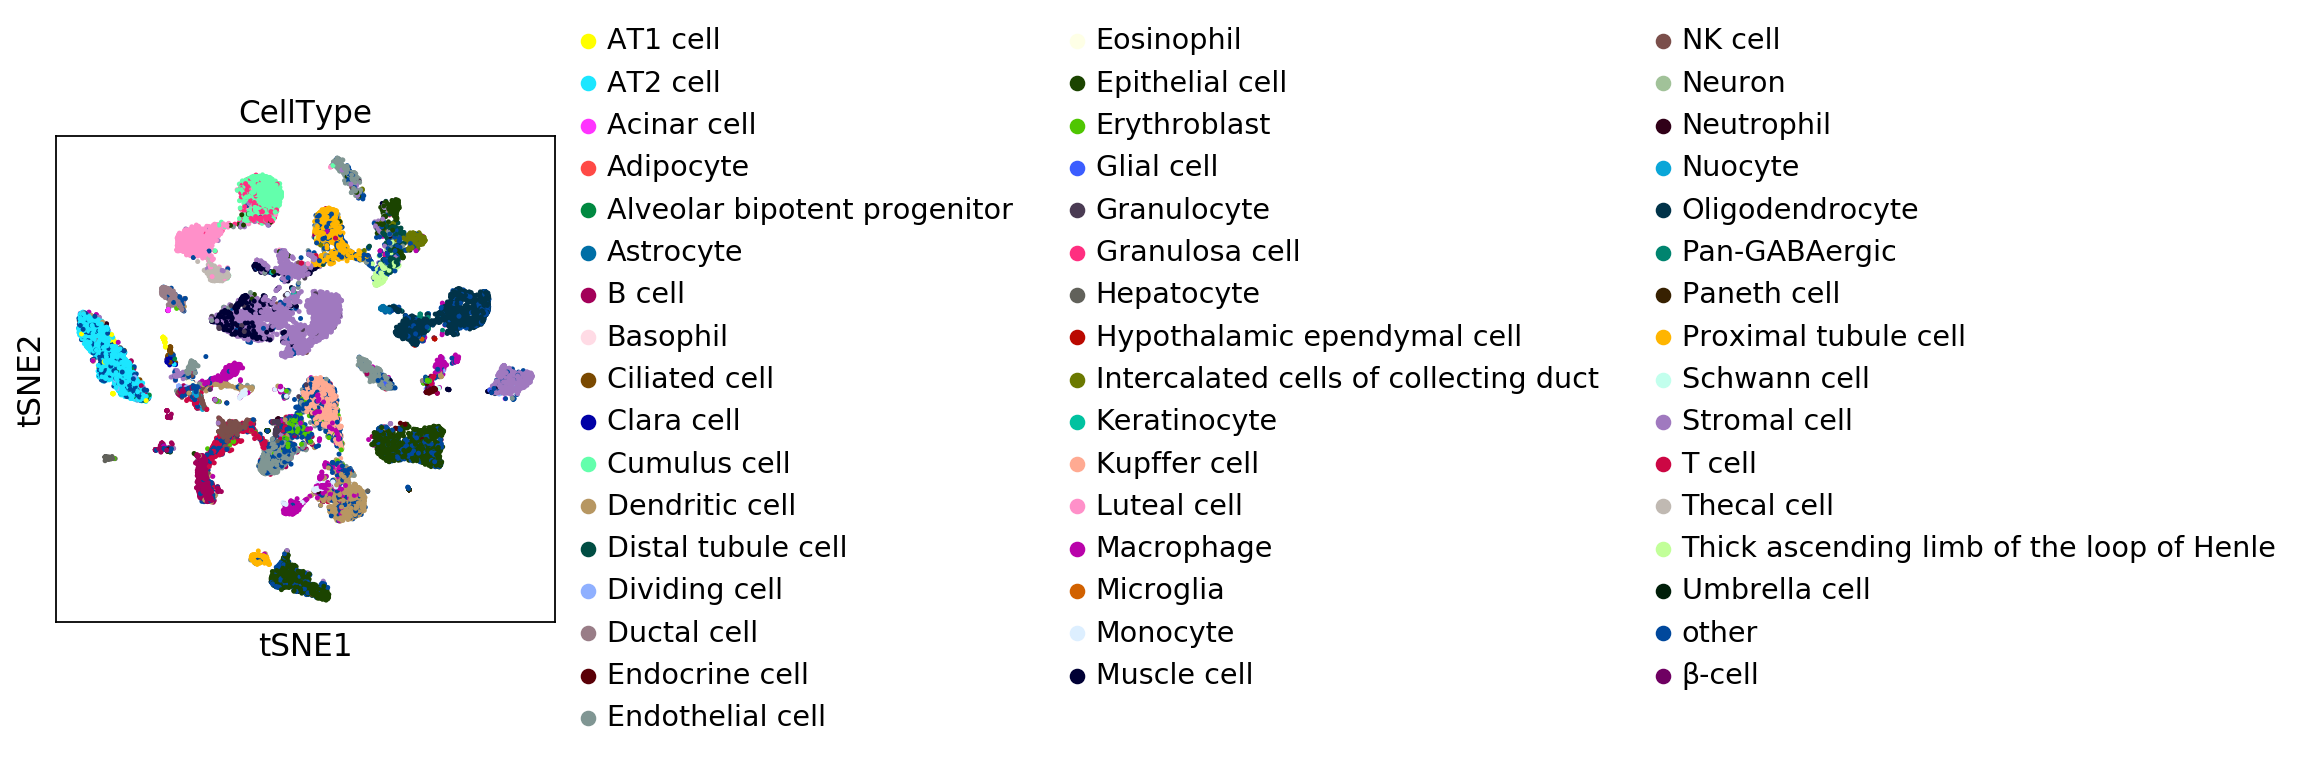

In [25]:
sc.pl.tsne(corrected_merged_dge, color=['CellType'], size=20, save="_CellType_Scanorama.svg")

saving figure to file ./figures/tsne_Tissue_Scanorama.svg


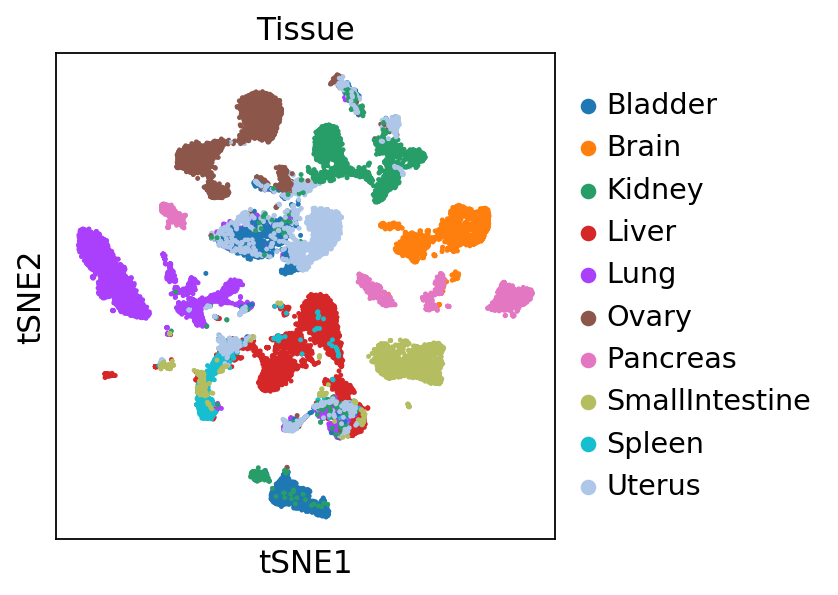

In [26]:
sc.pl.tsne(corrected_merged_dge, color=['Tissue'], size=20, save="_Tissue_Scanorama.svg")

saving figure to file ./figures/tsne_Cluster_Scanorama.svg


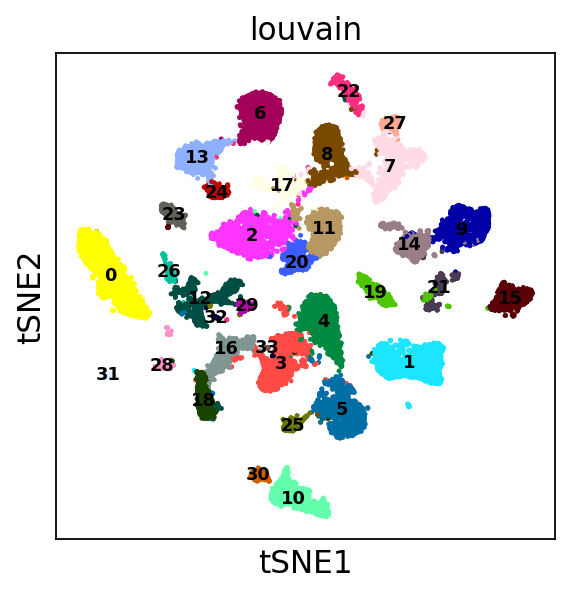

In [27]:
#res=0.6
sc.tl.louvain(corrected_merged_dge, resolution=0.6)
sc.pl.tsne(corrected_merged_dge, color='louvain',size=20,legend_loc='on data', legend_fontsize=8,save='_Cluster_Scanorama.svg')

In [105]:
corrected_merged_dge.obs['louvain'].to_csv("./cluster_Scanorama.txt", index=False)

In [29]:
mnn_adata = sc.read_h5ad("adata_mnns.h5ad")

In [30]:
mnn_adata.obs['Tissue'] = mnn_adata.obs_names.values
mnn_adata.obs['Tissue'] = mnn_adata.obs['Tissue'].apply(lambda x: x.split('_')[0])
mnn_adata.obs['Tissue'].unique()

array(['Liver', 'Lung', 'Spleen', 'Brain', 'Bladder', 'Ovary', 'Uterus',
       'Kidney', 'Pancreas', 'SmallIntestine'], dtype=object)

In [106]:
import mnnpy

In [107]:
logging.info("start MNNPY\n\n")
start = time.clock()
corrected = mnnpy.mnn_correct(*adata_list, var_subset=hvgs)
correct_end = time.clock()
mnn_adata = corrected[0]
merged_end = time.clock()
logging.info("time scale: second")
logging.info("MNNPY correct batch time:\t%f", correct_end - start)
logging.info("MNNPY merging time:\t%f", merged_end - correct_end)
logging.info("MNNPY total running time:\t%f", merged_end - start)
logging.info("\n\nend MNNPY")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 14: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 14: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 3 of 14: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 4 of 14: processing batch 4
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 5 of 14: processing batch 5
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 6 of 14: processing batch 6
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 7 of 14: processing batch 7
  Looking for MNNs...
  Computing correction vectors.

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [108]:
## scale the data
sc.pp.scale(mnn_adata, max_value=10)

In [109]:
## PCA
sc.tl.pca(mnn_adata)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [110]:
#nPC=45
sc.pp.neighbors(mnn_adata, n_neighbors=10,n_pcs=45)

In [111]:
#run tSNE
sc.tl.tsne(mnn_adata,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

... storing 'Tissue' as categorical


saving figure to file ./figures/tsne_Batch_MNNs.svg


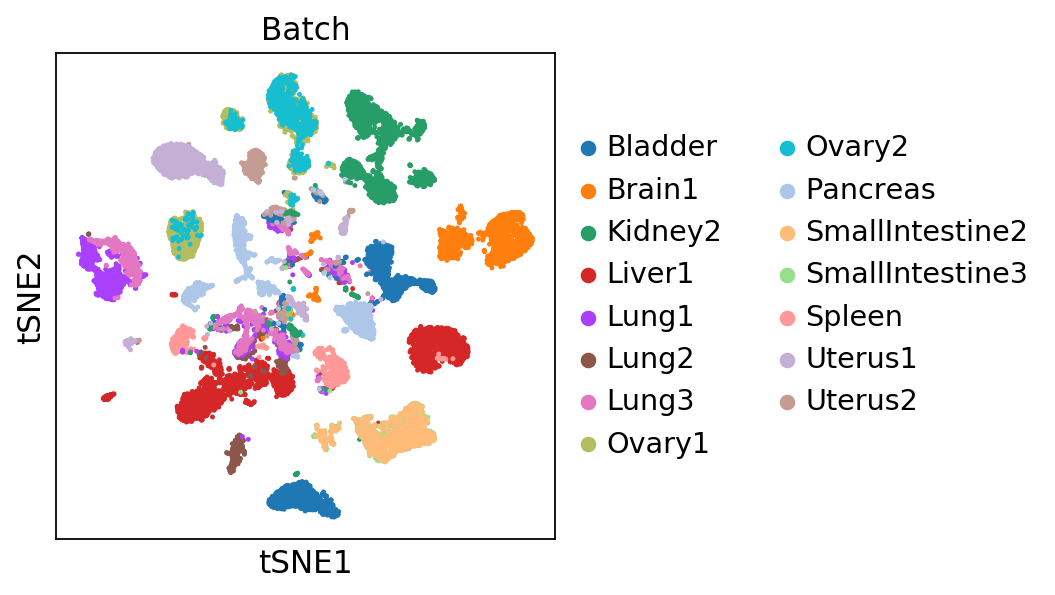

In [31]:
sc.pl.tsne(mnn_adata, color=['Batch'], size=20, save="_Batch_MNNs.svg")

saving figure to file ./figures/tsne_CellType_MNNs.svg


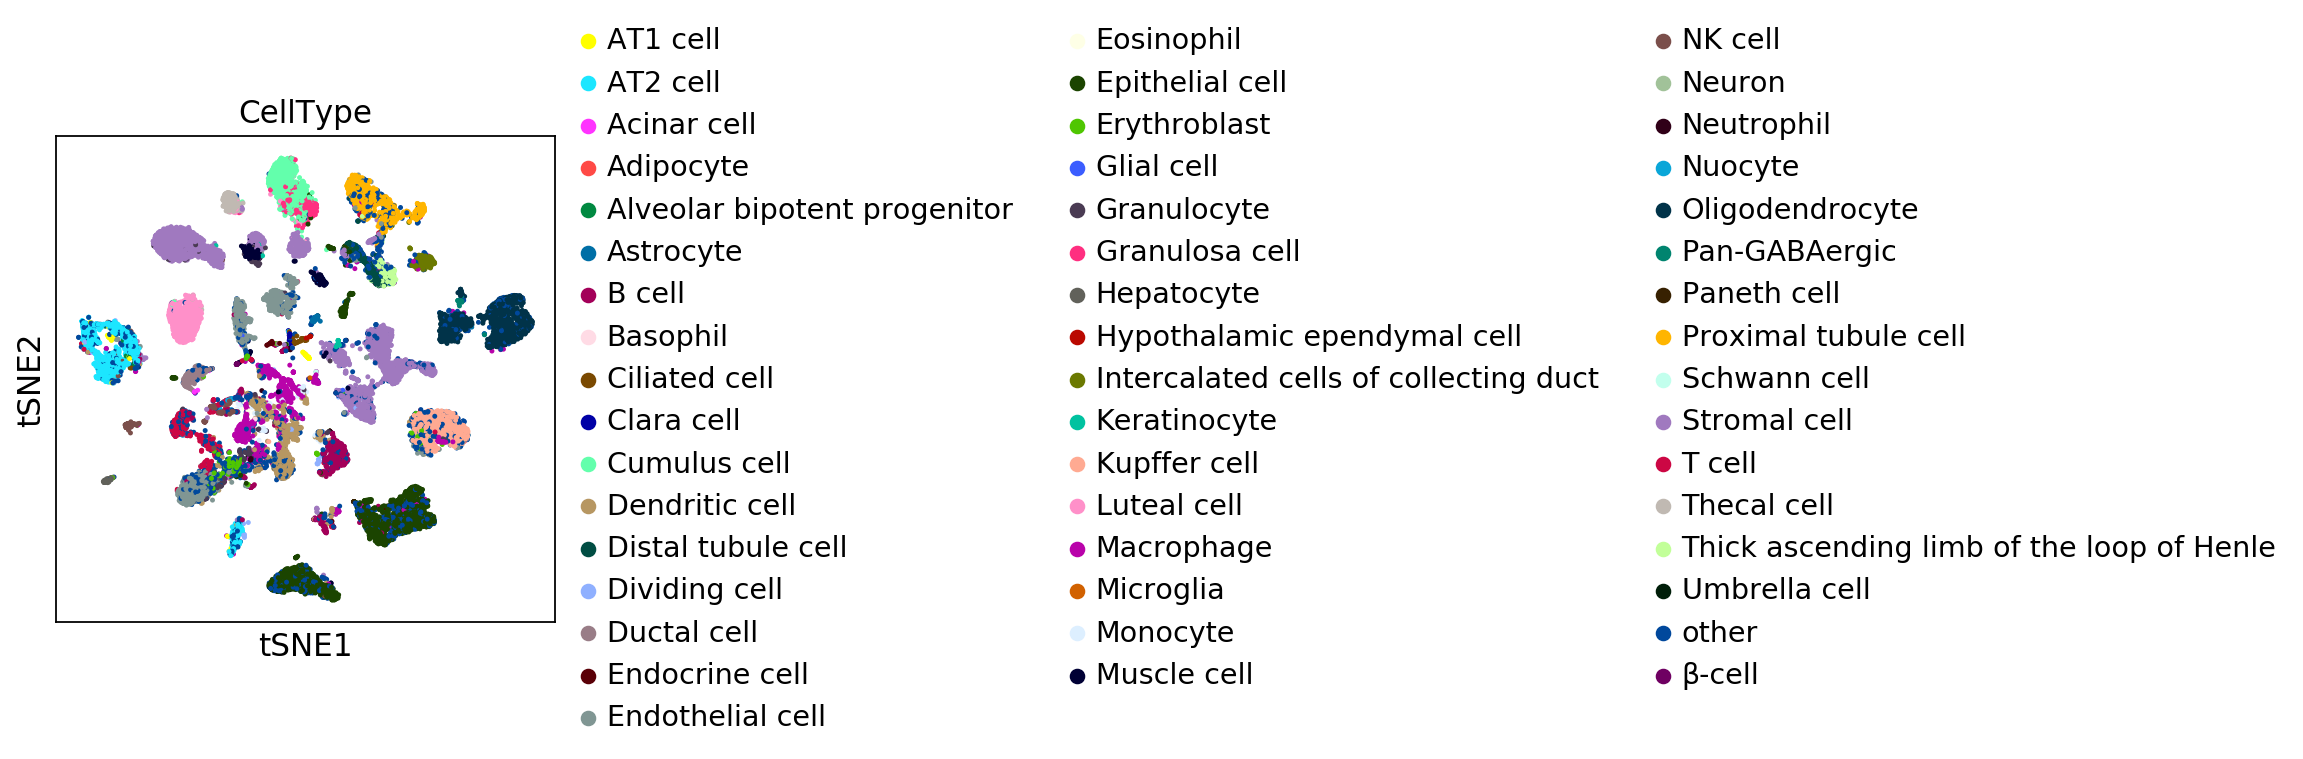

In [32]:
sc.pl.tsne(mnn_adata, color=['CellType'], size=20, save="_CellType_MNNs.svg")

saving figure to file ./figures/tsne_Tissue_MNNs.svg


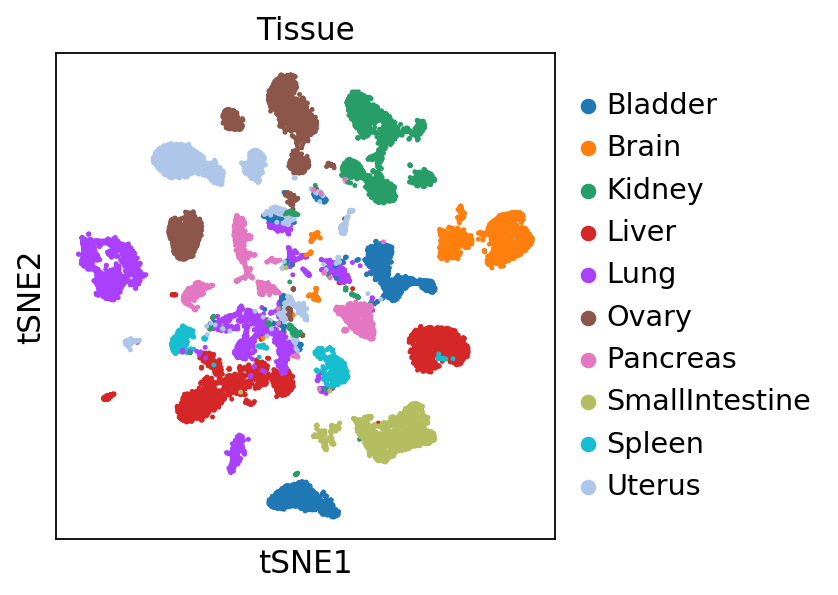

In [33]:
sc.pl.tsne(mnn_adata, color=['Tissue'], size=20, save="_Tissue_MNNs.svg")

saving figure to file ./figures/tsne_Cluster_MNNs.svg


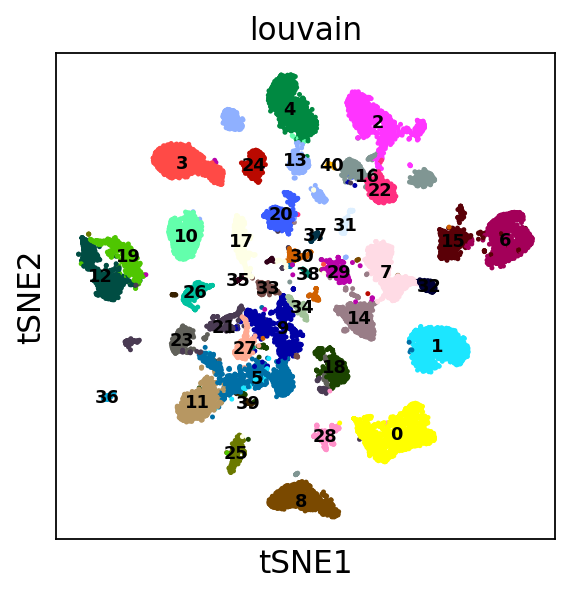

In [34]:
#res=0.6
sc.tl.louvain(mnn_adata, resolution=0.6)
sc.pl.tsne(mnn_adata, color='louvain',size=20,legend_loc='on data', legend_fontsize=8,save='_Cluster_MNNs.svg')

In [117]:
mnn_adata.obs['louvain'].to_csv("./cluster_MNNs.txt", index=False)

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from sklearn.metrics import silhouette_samples as sil

In [36]:
def calculate_silh(X, label_fname):
    labels = np.array( open(label_fname).read().rstrip().split() )
    idx = range(labels.shape[0])
    sil_val = sil(X[idx, :], labels[idx])
    print(np.median(sil_val))
    return sil_val

In [37]:
X = sc.read_h5ad("dge.h5ad").X

In [38]:
# Baseline Scanpy.
print("silh score of scanpy baseline")
sil_non = calculate_silh(X, './cluster_Baseline.txt')
# regout Scanpy
print("silh score of scanpy Regout:")
sil_regout = calculate_silh(X, 'cluster_reg.txt')
# regout Scanpy
print("silh score of scanpy Combat:")
sil_scanpy = calculate_silh(X, './cluster_Combat.txt')
# scanorama scanpy
print("silh score of Scanoram:")
sil_scano = calculate_silh(X,"./cluster_Scanorama.txt")
# MNNs
print("silh score of MNNs:")
sil_MNN = calculate_silh(X,"./cluster_MNNs.txt")

silh score of scanpy baseline
-0.280122
silh score of scanpy Regout:
-0.26473892
silh score of scanpy Combat:
-0.27205887
silh score of Scanoram:
-0.20503
silh score of MNNs:
-0.24538709


In [39]:
print("\n\n-----Ttest------\n\n")
# t-test
print("ttest of regout to baseline:")
print(ttest_ind(sil_regout, sil_non))
print("ttest of combat to baseline:")
print(ttest_ind(sil_scanpy, sil_non))
print("ttest of scanoram to baseline:")
print(ttest_ind(sil_scano, sil_non))
print("ttest of MNNs to baseline:")
print(ttest_ind(sil_MNN, sil_non))
print("ttest of Combat to Regout:")
print(ttest_ind(sil_scanpy, sil_regout))
print("ttest of Scanoram to Regout:")
print(ttest_ind(sil_scano, sil_regout))
print("ttest of MNNs to Regout:")
print(ttest_ind(sil_MNN, sil_regout))
print("ttest of Scanoram to Combat:")
print(ttest_ind(sil_scano, sil_scanpy))
print("ttest of MNNs to Combat:")
print(ttest_ind(sil_MNN, sil_scanpy))
print("ttest of MNNs to Scanoram:")
print(ttest_ind(sil_MNN, sil_scano))



-----Ttest------


ttest of regout to baseline:
Ttest_indResult(statistic=6.857337333199359, pvalue=7.094837857748063e-12)
ttest of combat to baseline:
Ttest_indResult(statistic=-2.0500818011510686, pvalue=0.040361525343583435)
ttest of scanoram to baseline:
Ttest_indResult(statistic=33.76133172734367, pvalue=3.798835136502611e-247)
ttest of MNNs to baseline:
Ttest_indResult(statistic=8.144565908624369, pvalue=3.8914597081418364e-16)
ttest of Combat to Regout:
Ttest_indResult(statistic=-8.996893835301394, pvalue=2.399146634900351e-19)
ttest of Scanoram to Regout:
Ttest_indResult(statistic=26.833503810741583, pvalue=1.6209985758595416e-157)
ttest of MNNs to Regout:
Ttest_indResult(statistic=1.4738471816095062, pvalue=0.14052888329678323)
ttest of Scanoram to Combat:
Ttest_indResult(statistic=36.255780609546754, pvalue=3.2405196955972376e-284)
ttest of MNNs to Combat:
Ttest_indResult(statistic=10.236354611252448, pvalue=1.4390765622182955e-24)
ttest of MNNs to Scanoram:
Ttest_indResult

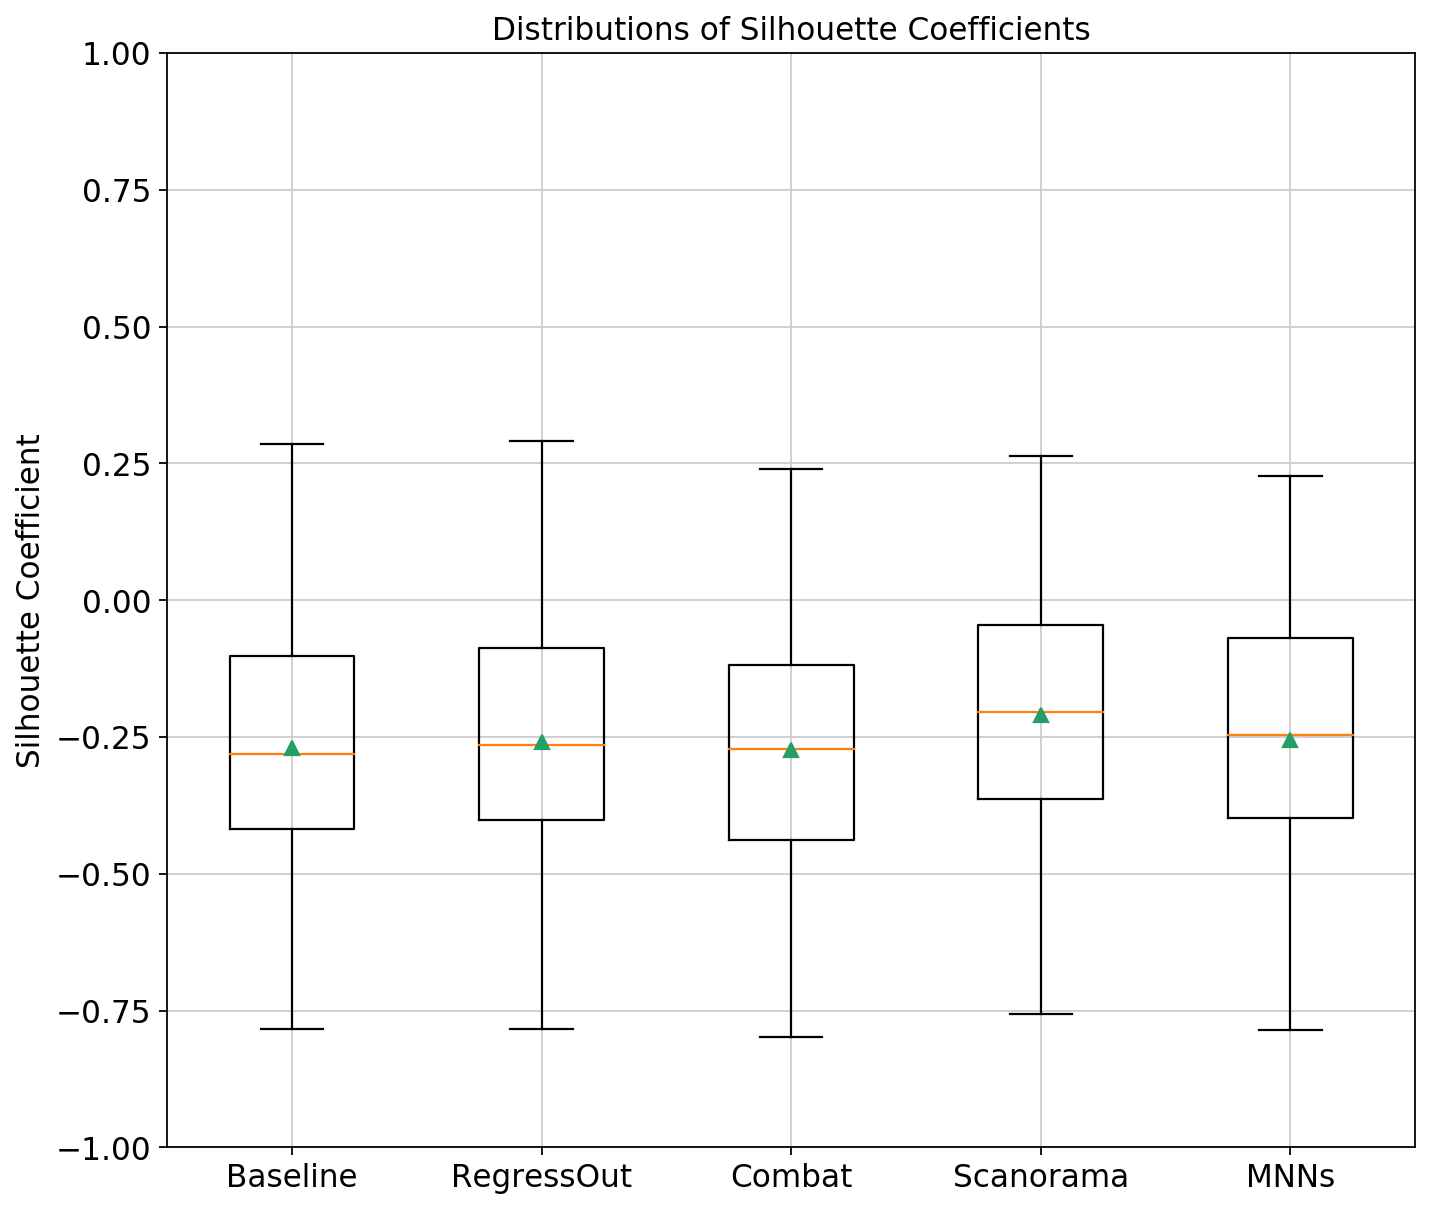

In [135]:
# visualization
plt.figure()
plt.boxplot([ sil_non, sil_regout, sil_scanpy, sil_scano, sil_MNN ], showmeans=True, whis='range')
plt.ylim([ -1, 1 ])
plt.title('Distributions of Silhouette Coefficients')
plt.xticks(range(1, 6), [ 'Baseline','RegressOut', 'Combat', 'Scanorama', "MNNs" ])
plt.ylabel('Silhouette Coefficient')
plt.savefig('silhouette_dge.svg')

In [136]:
X = adata.X

In [137]:
# Baseline Scanpy.
print("silh score of scanpy baseline")
sil_non = calculate_silh(X, './cluster_Baseline.txt')
# regout Scanpy
print("silh score of scanpy Regout:")
sil_regout = calculate_silh(X, 'cluster_reg.txt')
# regout Scanpy
print("silh score of scanpy Combat:")
sil_scanpy = calculate_silh(X, './cluster_Combat.txt')
# scanorama scanpy
print("silh score of Scanoram:")
sil_scano = calculate_silh(X,"./cluster_Scanorama.txt")
# MNNs
print("silh score of MNNs:")
sil_MNN = calculate_silh(X,"./cluster_MNNs.txt")

silh score of scanpy baseline
0.07899161
silh score of scanpy Regout:
0.091602705
silh score of scanpy Combat:
0.06941713
silh score of Scanoram:
0.1289698
silh score of MNNs:
0.071009845


In [139]:
print("\n\n-----Ttest------\n\n")
# t-test
print("ttest of regout to baseline:")
print(ttest_ind(sil_regout, sil_non))
print("ttest of regout to baseline:")
print(ttest_ind(sil_scanpy, sil_non))
print("ttest of scanoram to baseline:")
print(ttest_ind(sil_scano, sil_non))
print("ttest of MNNs to baseline:")
print(ttest_ind(sil_MNN, sil_non))



-----Ttest------


ttest of regout to baseline:
Ttest_indResult(statistic=7.778006402152251, pvalue=7.504634738673174e-15)
ttest of regout to baseline:
Ttest_indResult(statistic=-3.031575317840328, pvalue=0.0024340267107145755)
ttest of scanoram to baseline:
Ttest_indResult(statistic=15.301769459790387, pvalue=9.736029790663522e-53)
ttest of MNNs to baseline:
Ttest_indResult(statistic=-14.470806167221006, pvalue=2.29811078556226e-47)


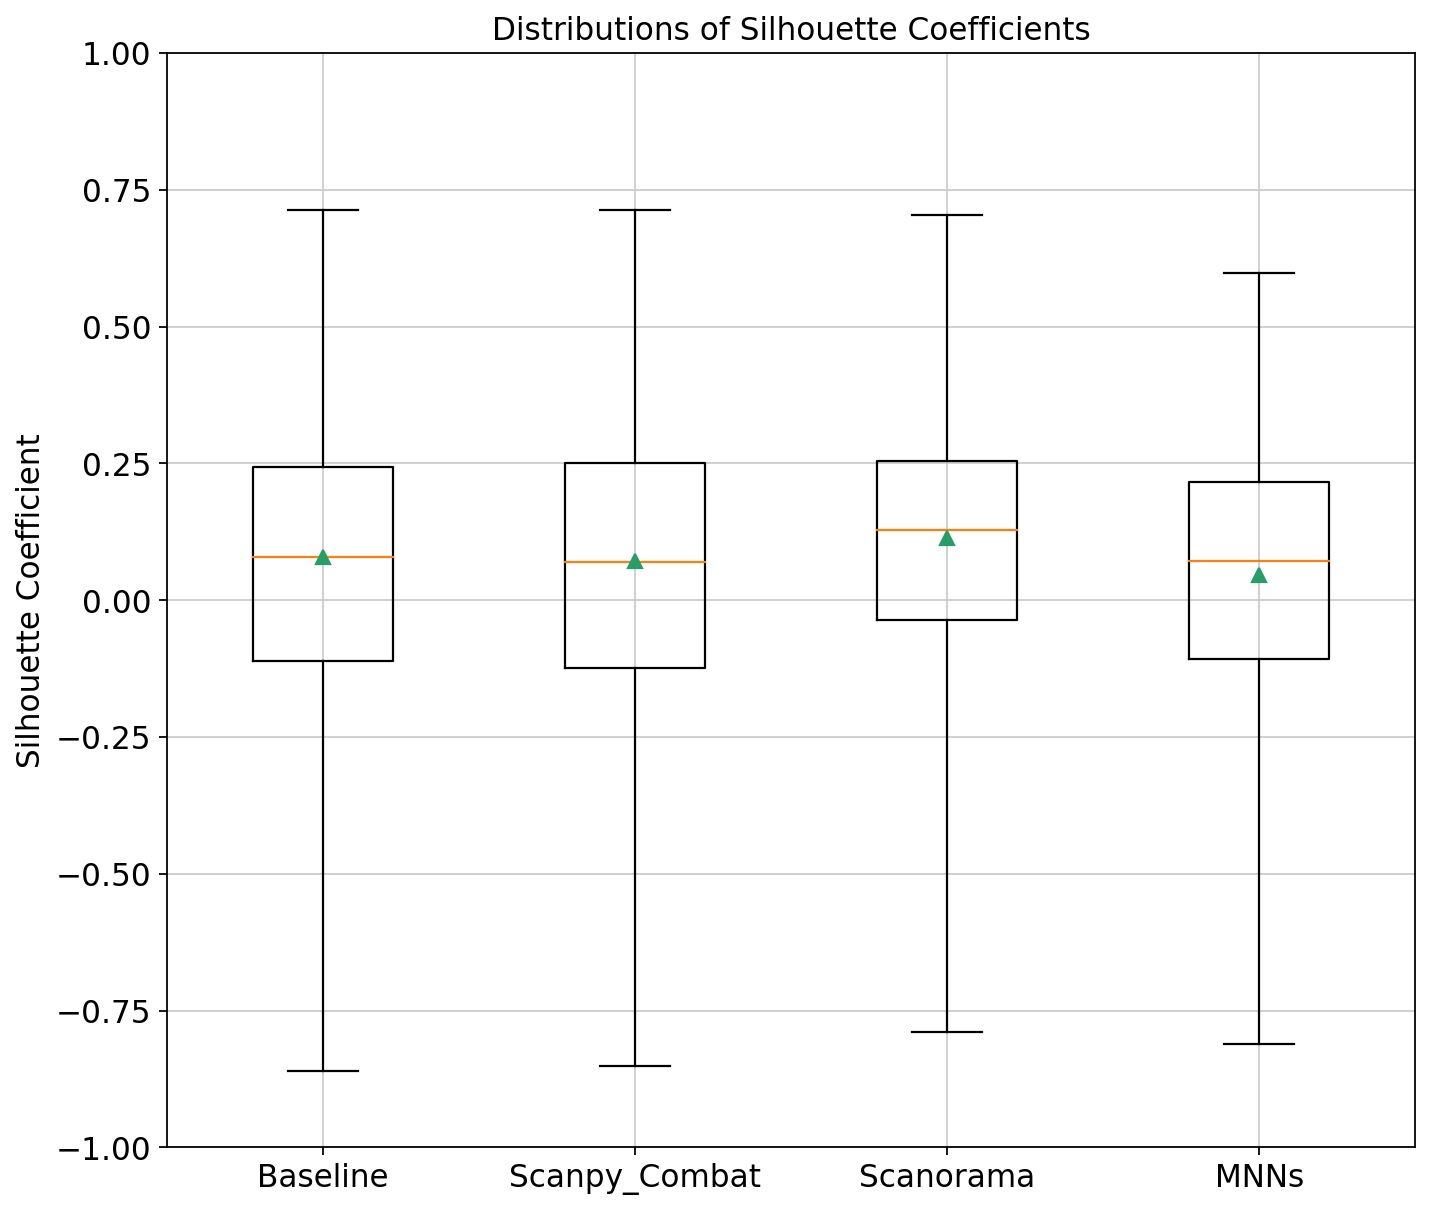

In [140]:
# visualization
plt.figure()
plt.boxplot([ sil_non, sil_scanpy, sil_scano, sil_MNN ], showmeans=True, whis='range')
plt.ylim([ -1, 1 ])
plt.title('Distributions of Silhouette Coefficients')
plt.xticks(range(1, 5), [ 'Baseline', 'Scanpy_Combat', 'Scanorama', "MNNs" ])
plt.ylabel('Silhouette Coefficient')
plt.savefig('silhouette_adata_norm.svg')

In [141]:
# Baseline Scanpy.
print("silh score of scanpy baseline")
sil_non = calculate_silh(adata_base.X, './cluster_Baseline.txt')
# Regout Scanpy.
print("silh score of scanpy Regout")
sil_non = calculate_silh(adata_reg.X, './cluster_Baseline.txt')
# regout Scanpy
print("silh score of scanpy Combat:")
sil_scanpy = calculate_silh(adata_combat.X, './cluster_Combat.txt')
# scanorama scanpy
print("silh score of Scanoram:")
sil_scano = calculate_silh(corrected_merged_dge.X,"./cluster_Scanorama.txt")
# MNNs
print("silh score of MNNs:")
sil_MNN = calculate_silh(mnn_adata.X,"./cluster_MNNs.txt")

silh score of scanpy baseline
-0.0578047
silh score of scanpy Regout
-0.05737736
silh score of scanpy Combat:
-0.0894321862055416
silh score of Scanoram:
-0.04342228
silh score of MNNs:
-0.15712409


In [142]:
print("\n\n-----Ttest------\n\n")
# t-test
print("ttest of regout to baseline:")
print(ttest_ind(sil_regout, sil_non))
print("ttest of regout to baseline:")
print(ttest_ind(sil_scanpy, sil_non))
print("ttest of scanoram to baseline:")
print(ttest_ind(sil_scano, sil_non))
print("ttest of MNNs to baseline:")
print(ttest_ind(sil_MNN, sil_non))



-----Ttest------


ttest of regout to baseline:
Ttest_indResult(statistic=76.25389530868732, pvalue=0.0)
ttest of regout to baseline:
Ttest_indResult(statistic=-57.57404964957896, pvalue=0.0)
ttest of scanoram to baseline:
Ttest_indResult(statistic=25.142518300571254, pvalue=1.1867053660985142e-138)
ttest of MNNs to baseline:
Ttest_indResult(statistic=-92.38705345666878, pvalue=0.0)


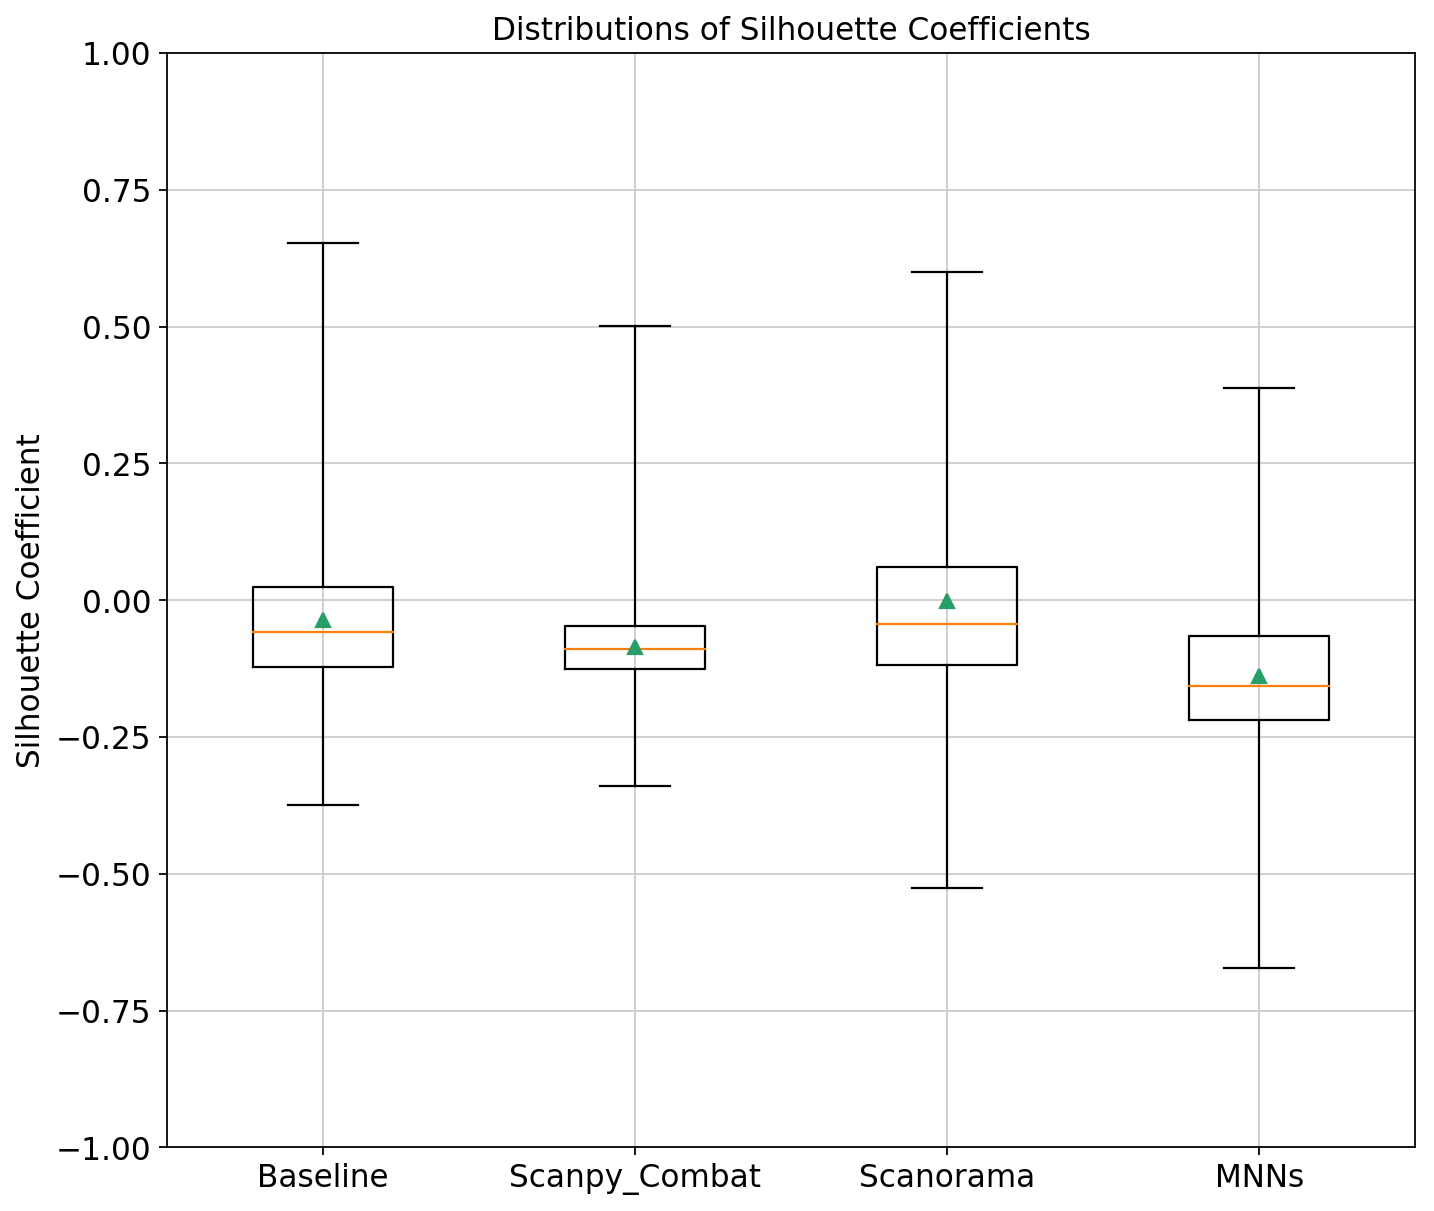

In [143]:
# visualization
plt.figure()
plt.boxplot([ sil_non, sil_scanpy, sil_scano, sil_MNN ], showmeans=True, whis='range')
plt.ylim([ -1, 1 ])
plt.title('Distributions of Silhouette Coefficients')
plt.xticks(range(1, 5), [ 'Baseline', 'Scanpy_Combat', 'Scanorama', "MNNs" ])
plt.ylabel('Silhouette Coefficient')
plt.savefig('silhouette_scaled.svg')

In [144]:
dge.write("./dge.h5ad")
adata.write("./adata.h5ad")
adata_base.write("./adata_base.h5ad")
adata_combat.write("./adata_combat.h5ad")
adata_reg.write("./adata_reg.h5ad")
corrected_merged_dge.write("./adata_scanorama.h5ad")
mnn_adata.write("./adata_mnns.h5ad")

... storing 'Cell.Anno' as categorical
... storing 'Tissue' as categorical
... storing 'CellType' as categorical
